#### MNIST Attack Notebook

In [1]:
%%capture installation
import os
import pickle
import argparse
import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from art.attacks.evasion import DeepFool, FastGradientMethod
from art.estimators.classification import PyTorchClassifier

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from typing import Callable, Tuple, Dict
from pathlib import Path
import pytorch_lightning as pl
from torch import nn

from dataloader import load_mnist
from models.autoencoder import (ANNAutoencoder, BaseAutoEncoder,
                                CelebAAutoencoder, CIFAR10Autoencoder, CIFAR10VAE,
                                CIFAR10LightningAutoencoder, CIFAR10NoisyLightningAutoencoder)
from models.classifier import (CelebAClassifier, CIFAR10Classifier,
                                MNISTClassifier)

from attacks import ATTACK_MAPPINGS, FastGradientMethod
from attacks.art_attack import execute_attack, get_models, get_xyz, hybridize
from attacks.plot_attack import plot_adversarial_images, plot_robust_accuracy
from dataloader import DATALOADER_MAPPINGS

In [290]:
class Args:
    batch_size = 300
    attack_name = "elastic"
    device  = "cuda"
    model_name = "mnist_ann_1"
    ae_name = "ann_128"
    plot = False
    plot_dir = "./plots"
    # kwargs = {}
    # kwargs = {"batch_size": 32, "nb_grads": 10, "epsilon": 0.0001} # deepfool
    # kwargs = {"eps": 0.5, "batch_size": 64} # pgd and fgsm and bim
    # kwargs = {"batch_size": 32, "theta": 0.3} # jsma
    # kwargs = {"batch_size": 64} # cnw
    kwargs = {"batch_size": 64, "targeted": False} # boundary and elastic and signopt

args = Args()

In [291]:
attack_name = ATTACK_MAPPINGS.get(args.attack_name)
dataset_name = args.model_name.split("_")[0]
print(f"Working on the dataset: {dataset_name}!!!!!")

with open(f"./configs/{dataset_name}.yml", "r") as f:
    config = yaml.safe_load(f)

classifier_model, autoencoder_model, config = get_models(args)
print(f"Loaded classifier and autoencoder models in eval mode!!!!!")

if dataset_name+".pkl" in os.listdir("./objects/"):
    print("Found saved dataset")
    fileObj = open("./objects/"+dataset_name+".pkl", 'rb')
    train_dataloader = pickle.load(fileObj)["data"]
    fileObj.close()
else:
    train_dataloader, _, _ = DATALOADER_MAPPINGS[config["dataset_name"]](batch_size=args.batch_size)
    obj = {"data": train_dataloader}
    fileObj = open("./objects/"+dataset_name+".pkl", 'wb')
    pickle.dump(obj, fileObj)
    fileObj.close()
print(f"Loaded dataloader!!!!!")

# ae = CIFAR10LightningAutoencoder()
# autoencoder_model = ae.from_pretrained('cifar10-resnet18').to(config["device"]).eval()

Working on the dataset: mnist!!!!!
Loaded classifier and autoencoder models in eval mode!!!!!
Found saved dataset
Loaded dataloader!!!!!


In [292]:
x, y, z = get_xyz(args, autoencoder_model, train_dataloader)
    
config["latent_shape"] = args.ae_name.split('_')[-1]
classifier, hybrid_classifier, accuracy = hybridize(x, y, z, 
                                                    config, classifier_model, autoencoder_model)

# Perform attack
conditionals = {
    "calculate_original": True,
    "is_class_constrained": False
}
result: Dict = execute_attack(config, attack_name, x, y, z, classifier, hybrid_classifier, autoencoder_model, args.kwargs, conditionals)

Accuracy on benign test examples: 100.0%
Accuracy on benign test examples(from reconstructed): 100.0%


EAD: 100%|██████████| 5/5 [02:41<00:00, 32.29s/it]


Robust accuracy of original adversarial attack: 0.0%


EAD: 100%|██████████| 5/5 [03:33<00:00, 42.67s/it]

Robust accuracy of modified adversarial attack: 27.0%
Robust accuracy of reconstructed adversarial attack: 0.0%


: 

In [276]:
if conditionals["calculate_original"]:
    x_adv = result[attack_name.__name__]["x_adv"]
    delta_x = result[attack_name.__name__]["delta_x"]

x_hat_adv  = result[attack_name.__name__]["x_hat_adv"]
modf_x_adv = result[attack_name.__name__]["modf_x_adv"]

# noises
delta_x_hat = result[attack_name.__name__]["delta_x_hat"]

import torchvision
def plot_images(images):
    plt.figure(figsize=(20, 2))
    images = torch.Tensor(images).reshape(-1, 1, 28, 28)
    # i = 1
    # for image in images:
    #     plt.subplot(5, 5, i, xticks=[], yticks=[])
    #     plt.imshow(np.transpose(image, (1, 2, 0)))
    #     i = i + 1

    #     if i == 26:
    #         break
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

def plot_batch(images):
    plt.figure(figsize=(20, 10))
    images = torch.Tensor(images).reshape(-1, 1, 28, 28)
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

start = 0
end   = 10

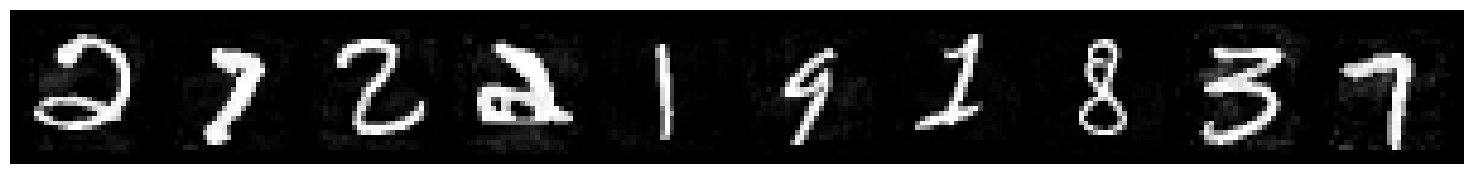

In [277]:
if conditionals["calculate_original"]:
    plot_images(x_adv[start: end])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


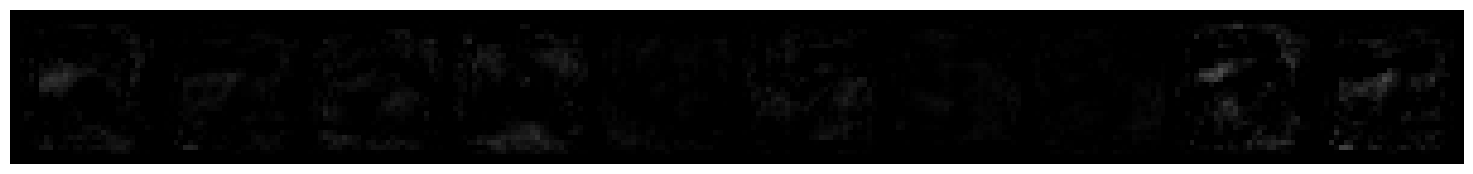

In [278]:
if conditionals["calculate_original"]:
    plot_images(delta_x[start: end])

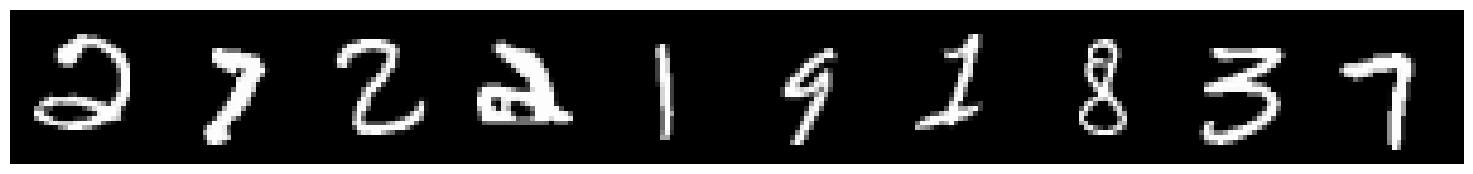

In [279]:
plot_images(x[1][start: end])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


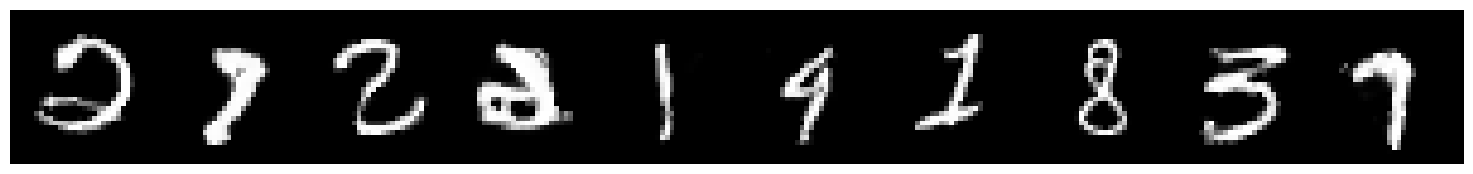

In [280]:
plot_images(modf_x_adv[start: end])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


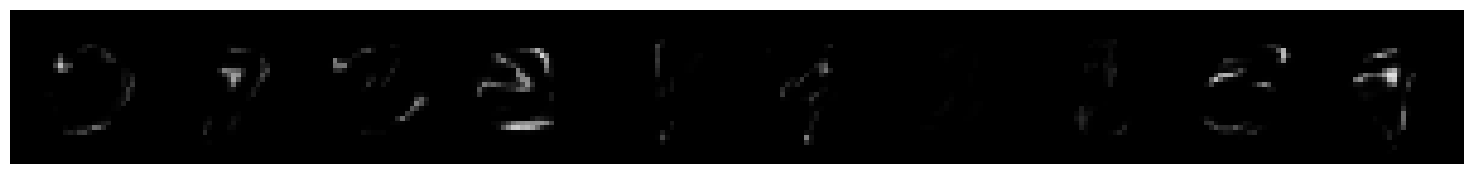

In [281]:
plot_images(delta_x_hat[start: end])

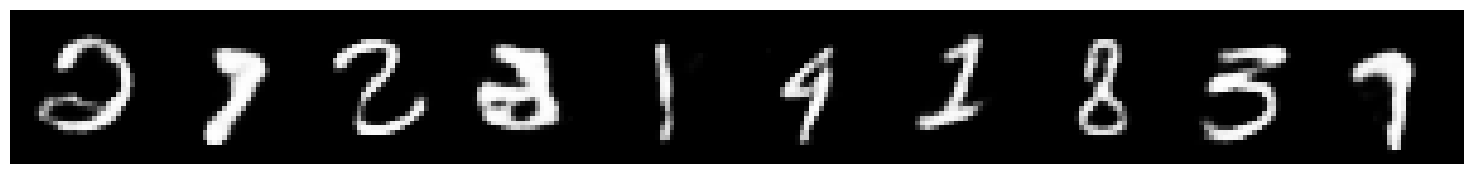

In [282]:
plot_images(x_hat_adv[start: end])

#### LPIPS Similarity Score

In [283]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores

# LPIPS between original and original attacks
import torch
img_orig = torch.Tensor(x_adv) # image should be RGB, IMPORTANT: normalized to [-1,1]
# img_modf = torch.Tensor(x_hat_adv)
img_modf = torch.Tensor(modf_x_adv)
img = x[0].detach().cpu()

orig_lpips = loss_fn_alex(img, img_orig)
modf_lpips = loss_fn_alex(img, img_modf)
print("Average LPIPS score of original adversarial attack: ", orig_lpips.flatten().mean())
print("Average LPIPS score of modifed adversarial attack: ", modf_lpips.flatten().mean())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/harsh/anaconda3/envs/py38/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Average LPIPS score of original adversarial attack:  tensor(0.0418, grad_fn=<MeanBackward0>)
Average LPIPS score of modifed adversarial attack:  tensor(0.0484, grad_fn=<MeanBackward0>)


In [284]:
## Harmonic Means
orig_acc = result[attack_name.__name__]["x_adv_acc"]
modf_acc = result[attack_name.__name__]["x_hat_adv_acc"]

orig_lpips_avg = orig_lpips.flatten().mean()
modf_lpips_avg = modf_lpips.flatten().mean()

orig_hm = (orig_acc * orig_lpips_avg) / (orig_acc + orig_lpips_avg)
modf_hm = (modf_acc * modf_lpips_avg) / (modf_acc + modf_lpips_avg)

print(f"Original HM: {orig_hm}, Modified HM: {modf_hm}")

Original HM: 0.0, Modified HM: 0.0058601973578333855


#### Calculating L2 and Linf Norm

In [250]:
orig_linf = torch.max(torch.abs(x[0] - img_orig.to(device)))
modf_linf = torch.max(torch.abs(x[0] - img_modf.to(device)))

print("Average Linf distance between original and original adversarial images: ", orig_linf.mean())
print("Average Linf distance between original and modified adversarial images: ", modf_linf.mean())

Average Linf distance between original and original adversarial images:  tensor(0.3651, device='cuda:0')
Average Linf distance between original and modified adversarial images:  tensor(0.9955, device='cuda:0')


In [251]:
orig_l2 = torch.cdist(x[0], img_orig.to(device), p=2)
modf_l2 = torch.cdist(x[0], img_modf.to(device), p=2)
print("Average L2 distance between original and original adversarial images: ", orig_l2.mean())
print("Average L2 distance between original and modified adversarial images: ", modf_l2.mean())

Average L2 distance between original and original adversarial images:  tensor(9.8715, device='cuda:0')
Average L2 distance between original and modified adversarial images:  tensor(9.9432, device='cuda:0')


In [286]:
# save adversarial images
fileObj = open(f"./objects/{dataset_name}/{args.attack_name}.pkl", 'wb')
pickle.dump(result, fileObj)
fileObj.close()

#### Robust Bench Benchmarks

In [25]:
from robustbench.utils import load_model

model = load_model(model_name='Carmon2019Unlabeled', dataset='cifar10', threat_model='Linf')
# model = load_model(model_name='Engstrom2019Robustness', dataset='cifar10', threat_model='Linf')
# model = load_model(model_name='Rice2020Overfitting', dataset='cifar10', threat_model='Linf')

In [26]:
criterion = nn.CrossEntropyLoss()
classifier = PyTorchClassifier( 
    model=model,
    clip_values=(0, 1),
    loss=criterion,
    # optimizer=optimizer,
    input_shape=(32, 32),
    nb_classes=10,
)

orig_preds = classifier.predict(x_adv)
modf_preds = classifier.predict(x_hat_adv)
orig_acc = np.sum(np.argmax(orig_preds, axis=-1) == y[1]) / len(y[1])
modf_acc = np.sum(np.argmax(modf_preds, axis=-1) == y[1]) / len(y[1])
print("Robust original accuracy: ", orig_acc)
print("Robust modified accuracy: ", modf_acc)

Robust original accuracy:  0.7266666666666667
Robust modified accuracy:  0.25


#### Finding Border

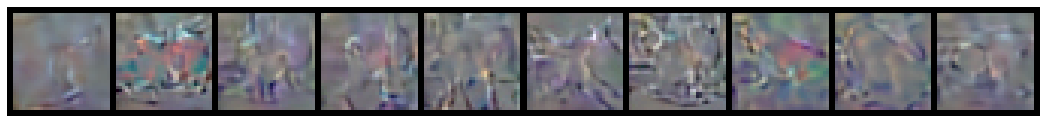

In [82]:
z = autoencoder_model.get_z(x[0][start: end])
noisy_z = z + 0.0001
x_hat = autoencoder_model.get_x_hat(z)
noisy_x_hat = autoencoder_model.get_x_hat(noisy_z)
delta = noisy_x_hat - x_hat
plot_images(delta.cpu().detach())